In [11]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from haversine import haversine, Unit
from sklearn.metrics.pairwise import haversine_distances
from tqdm import tqdm
from matplotlib.colors import ListedColormap, BoundaryNorm, LogNorm
import pandas as pd
from xhistogram.xarray import histogram
from sklearn.neighbors import KNeighborsRegressor, BallTree
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import linregress
import cmocean

def haversine_sklearn(lat1, lon1, lat_array, lon_array):


    X = np.array([lat1, lon1]).reshape(1, -1)
    Y = np.array([lat_array, lon_array]).T
    X = np.radians(X)
    Y = np.radians(Y)

    return haversine_distances(X, Y) * 6357
from matplotlib.colors import BoundaryNorm

colors = np.array([[0.10588235, 0.61960784, 0.46666667, 1.],
                [0.45882353, 0.43921569, 0.70196078, 1.],
                [0.4       , 0.4       , 0.4       , 1.],
                [0.90196078, 0.67058824, 0.00784314, 1.],
])

cmap = ListedColormap(colors)
#cmap = plt.get_cmap('Dark2')
bounds = [1, 2, 3, 4, 5]
norm = BoundaryNorm(bounds, cmap.N)
# Create a figure and axis with the specified size

SIC = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_unified_data/amsr_modis_sic.nc').sortby('time')
ds = xr.open_dataset('../../data/ar/HALO-AC3_HALO_VELOX_segmentation_statistics_with_sea_ice_edge_distance.nc')

fontsize = 8

plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.segment_idsize']  = fontsize
plt.rcParams['axes.titlesize']  = fontsize
plt.rcParams['xtick.segment_idsize'] = fontsize
plt.rcParams['ytick.segment_idsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['legend.title_fontsize'] = fontsize
plt.rcParams['figure.titlesize'] = fontsize
plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.axisbelow'] = True
sc_cmap = 'Dark2'


cmap = ListedColormap(colors)



def area_weighted_mean(x, w):
    return np.nansum(x * w) / np.nansum(w)

### calc the area weighted mean of T

awm = area_weighted_mean(ds['segment_T'].values, ds['segment_size'].values)
m = ds['segment_T'].mean().values

print(awm, m)   

ds_sam = xr.open_dataset('../../data/to_pangaea/HALO-AC3_HALO_VELOX_2022-04-04T14:08:00_2022-04-04T14:30:00.nc', engine='netcdf4')


-20.916633036886214 -15.185332


In [42]:
ds_sam['t_ref'] = ds_sam.where((ds_sam.surface_type!=1) & (ds_sam.surface_type !=2)).min(dim='y').t_skin
ds_sam['t_anamoly'] = ds_sam.t_skin - ds_sam.t_ref
#ds_sam['t_anamoly'] = ds_sam.t_anamoly.where(ds_sam.t_anamoly > 5)

In [110]:
# Apply Flox-based aggregation
from flox.xarray import xarray_reduce
unique_ws = np.unique(ds_sam['segment_id'].values)

segment_area = xarray_reduce(ds_sam['segment_id'], ds_sam['segment_id'], func='count', engine='flox', expected_groups=unique_ws)
segment_T = xarray_reduce(ds_sam['t_skin'], ds_sam['segment_id'], func='nanmean', engine='flox', expected_groups=unique_ws)
segment_std = xarray_reduce(ds_sam['t_skin'], ds_sam['segment_id'], func='nanstd', engine='flox', expected_groups=unique_ws)
segment_segment_id = xarray_reduce(ds_sam['segment_id'], ds_sam['segment_id'], func='nanmode', engine='numpy', expected_groups=unique_ws)
segment_lat = xarray_reduce(ds_sam['lat'], ds_sam['segment_id'], func='nanmean', engine='flox', expected_groups=unique_ws)
segment_lon = xarray_reduce(ds_sam['lon'], ds_sam['segment_id'], func='nanmean', engine='flox', expected_groups=unique_ws)
segment_anomaly = xarray_reduce(ds_sam['t_anamoly'], ds_sam['segment_id'], func='nanmean', engine='flox', expected_groups=unique_ws)

# Store results in dataset
ds_segstats = xr.Dataset(
    data_vars={
        'segment_size': ('segment', segment_area.values),
        'segment_T': ('segment', segment_T.values),
        'segment_std': ('segment', segment_std.values),
        'segment_segment_id': ('segment', segment_segment_id.values),
        'segment_area': ('segment', segment_area.values),
        'segment_lat': ('segment', segment_lat.values),
        'segment_lon': ('segment', segment_lon.values),
        'segment_anomaly': ('segment', segment_anomaly.values),
    },
    coords={'segment': np.arange(len(segment_area))}
)

ds_segstats = ds_segstats.where(ds_segstats.segment_size > 10, drop=True)


In [112]:
ds_segstats

<xarray.Dataset> Size: 197kB
Dimensions:             (segment: 3784)
Coordinates:
  * segment             (segment) int64 30kB 0 1 2 3 ... 29860 29861 29873 29938
Data variables:
    segment_size        (segment) float64 30kB 1.33e+06 5.319e+03 ... 101.0 52.0
    segment_T           (segment) float32 15kB -13.31 nan nan ... -18.39 -15.4
    segment_std         (segment) float32 15kB 1.78 nan nan ... 0.803 0.8043
    segment_segment_id  (segment) float64 30kB 1.0 2.0 ... 2.987e+04 2.994e+04
    segment_area        (segment) float64 30kB 1.33e+06 5.319e+03 ... 101.0 52.0
    segment_lat         (segment) float32 15kB 76.8 76.91 76.91 ... 76.04 75.82
    segment_lon         (segment) float32 15kB -4.802 -4.358 ... -9.193 -7.592
    segment_anomaly     (segment) float32 15kB 6.424 nan nan ... 5.405 5.05

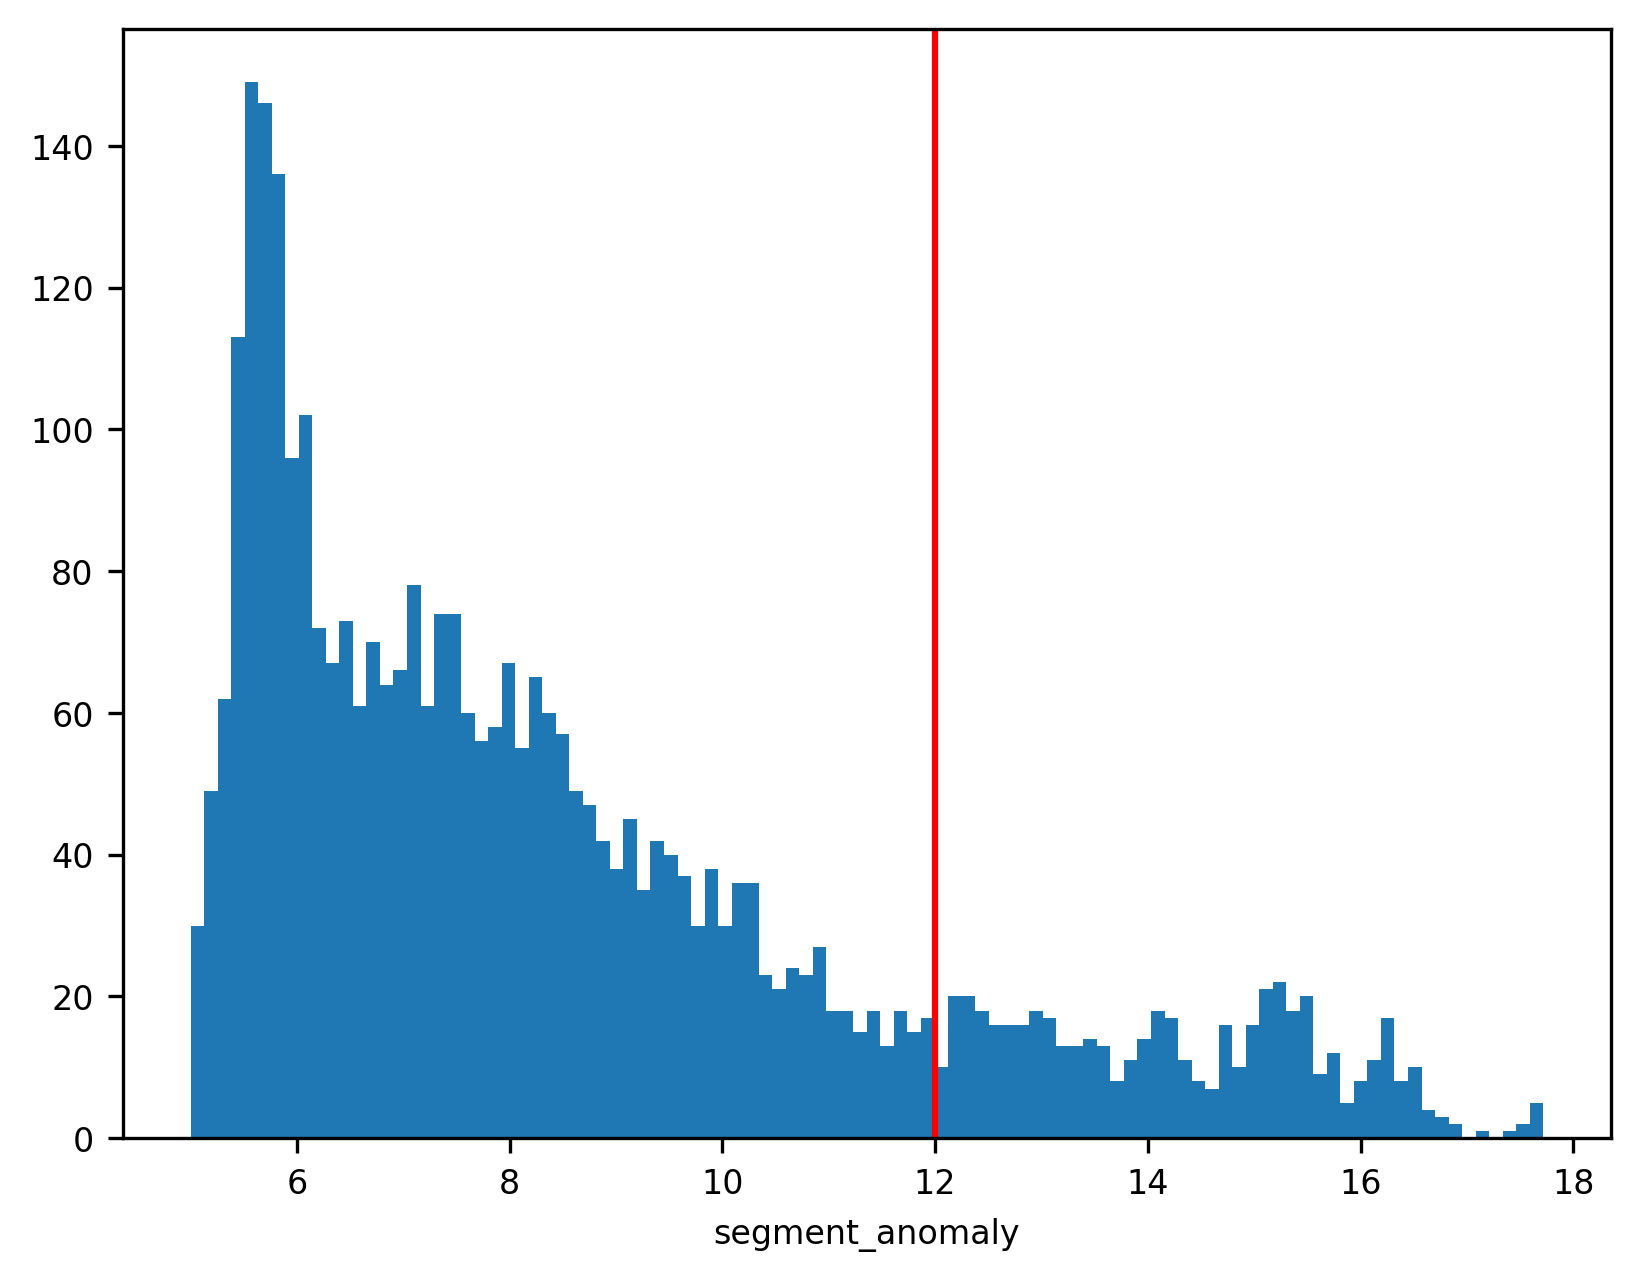

In [113]:
ds_segstats['segment_anomaly'].plot.hist(bins=100)
plt.axvline(12, color='r')
plt.show()

/tmp/ipykernel_3309290/871905497.py:13: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(hist)
/tmp/ipykernel_3309290/871905497.py:37: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(hist)


-0.46279410753438266 -0.8058641343351147 -0.894346759257231 1.281299993333975e-16 0.035303584768310636
-0.5366853565944438 -0.5849443251363187 0.9424152719545367 9.510594258809432e-46 0.015744289754831765


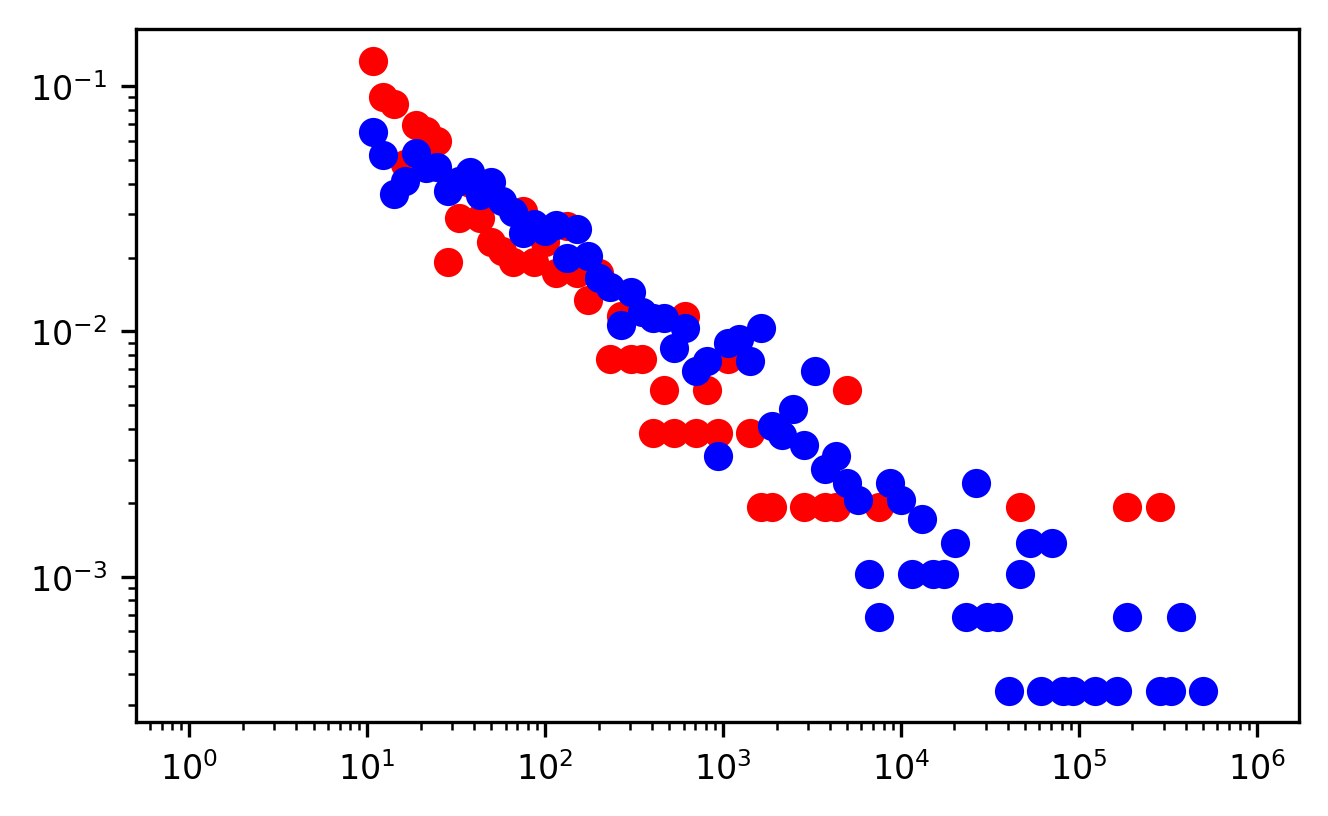

In [116]:
bins = np.logspace(0, 6, 100)

ds_leads = ds_segstats.where(ds_segstats.segment_anomaly > 12, drop=True)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

hist, bins = np.histogram(ds_leads['segment_size'].values, bins=bins)
hist = hist / hist.sum()

from scipy.stats import linregress

x = np.log10(bins[:-1])
y = np.log10(hist)
nan_mask = np.isfinite(x) & np.isfinite(y)

x = x[nan_mask]
y = y[nan_mask]
slope, intercept, r_value, p_value, std_err = linregress(x, y)

print(slope, intercept, r_value, p_value, std_err)


ax.scatter(bins[:-1], hist, label='leads', color='r')

ax.set_yscale('log')
ax.set_xscale('log')


ds_leads = ds_segstats.where(ds_segstats.segment_anomaly < 12, drop=True)


hist, bins = np.histogram(ds_leads['segment_size'].values, bins=bins)
hist = hist / hist.sum()


x = np.log10(bins[:-1])
y = np.log10(hist)
nan_mask = np.isfinite(x) & np.isfinite(y)

x = x[nan_mask]
y = y[nan_mask]

slope, intercept, r_value, p_value, std_err = linregress(x, y)  

print(slope, intercept, r_value**2, p_value, std_err)

ax.scatter(bins[:-1], hist, label='leads', color='b')

ax.set_yscale('log')
ax.set_xscale('log')




In [117]:
lead_segments = ds_segstats.where(ds_segstats.segment_anomaly > 12, drop=True)['segment_segment_id']

In [130]:
ds_leads_2d = ds_sam.where(ds_sam.segment_id.isin(lead_segments), drop=False)

In [131]:
ds_leads_2d['segment_id'] = ds_leads_2d['segment_id']
ds_leads_2d

<xarray.Dataset> Size: 650MB
Dimensions:       (y: 635, time: 28407)
Coordinates:
  * time          (time) datetime64[ns] 227kB 2022-04-04T14:08:00 ... 2022-04...
  * y             (y) int64 5kB -317 -316 -315 -314 -313 ... 313 314 315 316 317
Data variables:
    lon           (y, time) float32 72MB nan nan nan nan nan ... nan nan nan nan
    lat           (y, time) float32 72MB nan nan nan nan nan ... nan nan nan nan
    t_skin        (y, time) float32 72MB nan nan nan nan nan ... nan nan nan nan
    surface_type  (y, time) float64 144MB nan nan nan nan ... nan nan nan nan
    segment_id    (y, time) float64 144MB nan nan nan nan ... nan nan nan nan
    t_ref         (time, y) float32 72MB nan nan nan nan nan ... nan nan nan nan
    t_anamoly     (y, time) float32 72MB nan nan nan nan nan ... nan nan nan nan
Attributes:
    title:         Two dimensional surface type classification and surface te...
    institution:   Leipzig University, Leipzig Institute for Meteorology
    contact:       joshua.mueller@uni-leipzig.de
    instrument:    VELOX
    campaign:      HALO-AC3
    created_on:    2024-12-16
    history:       2024-06-12: first version with georeference \n 2024-11-16:...
    author:        Joshua Müller, Michael Schäfer, Sophie Rosenburg and Manfr...
    comment:       Thermal infrared imager information: focal length: 15 mm, ...
    references_1:  VELOX surface retrieval paper: (in submission)
    references_2:  VELOX tech. paper: https://doi.org/10.5194/amt-15-1491-2022
    references_3:  HALO-AC3 campaign: https://doi.org/10.5194/acp-24-8865-2024

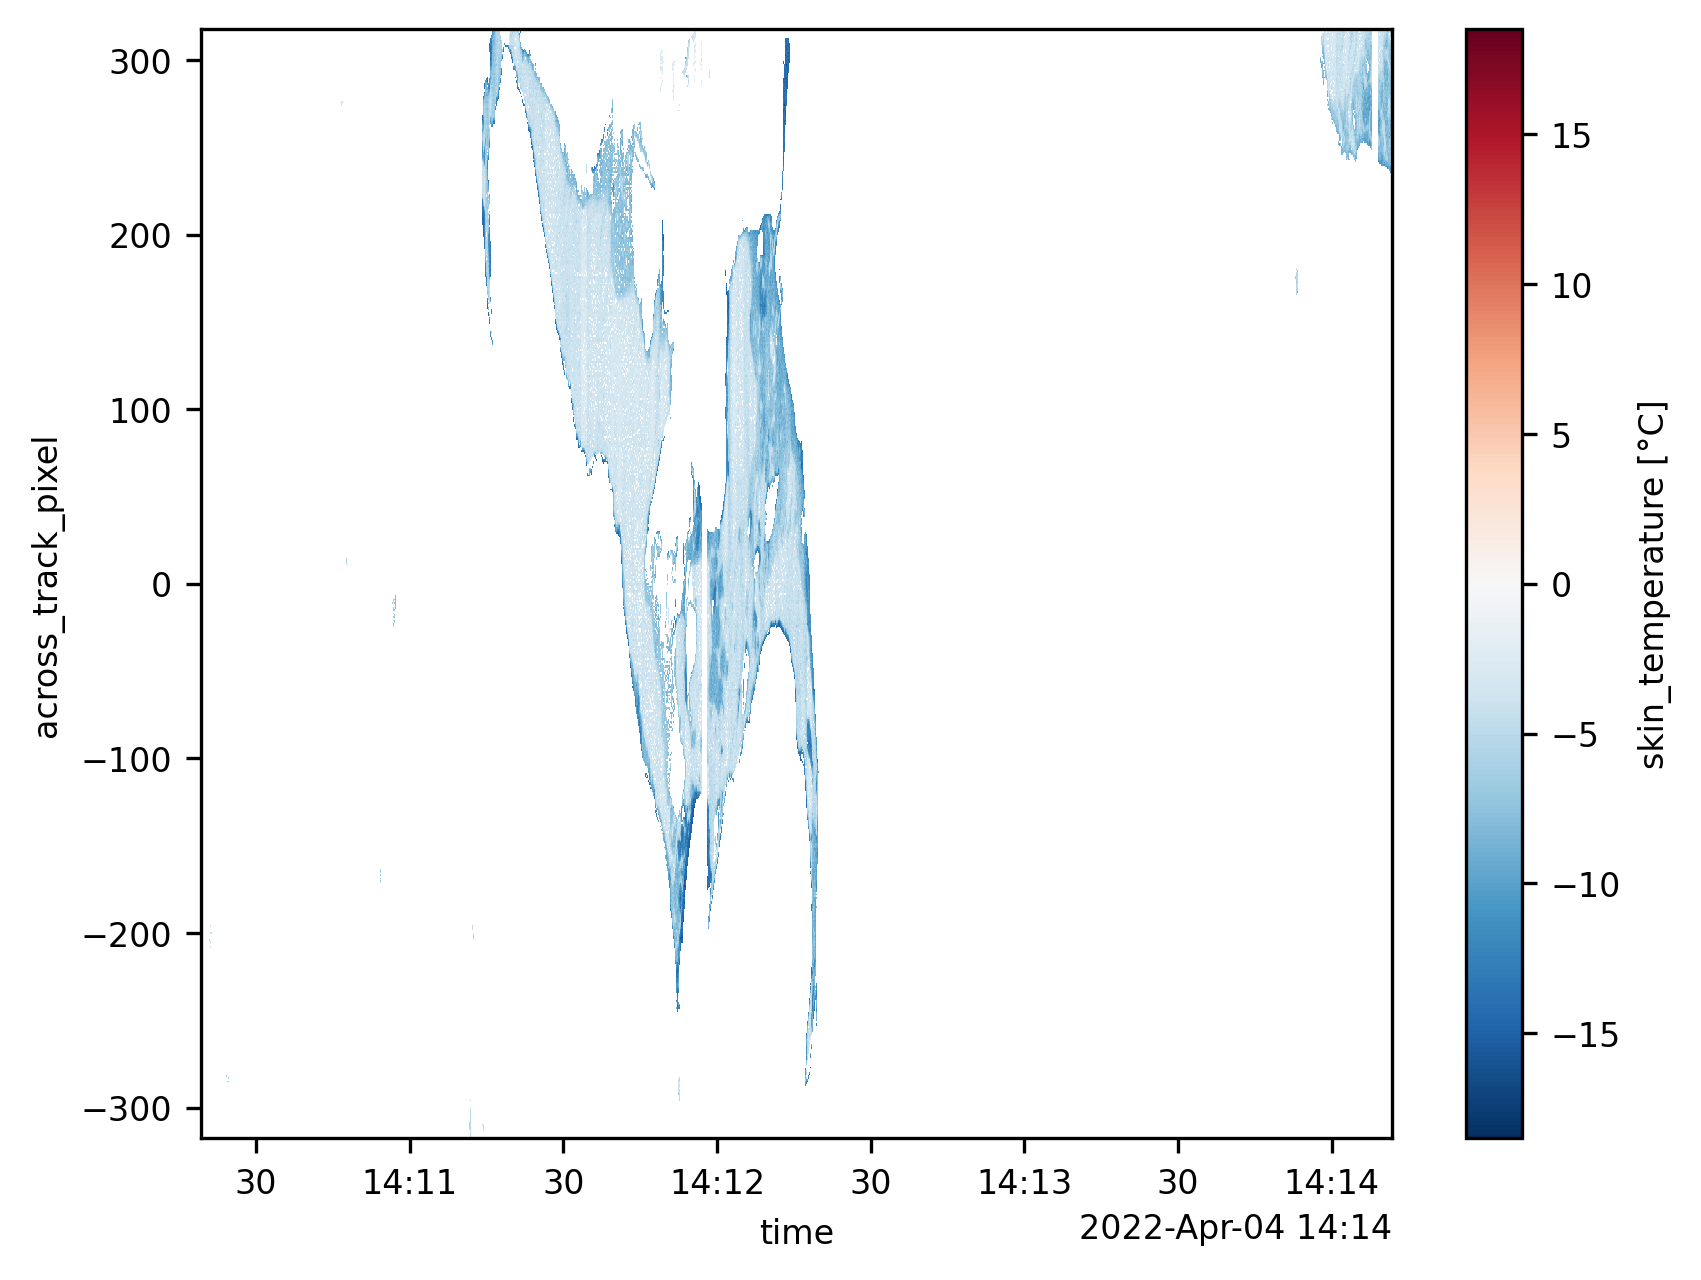

In [136]:
ds_leads_2d.t_skin.isel(time=slice(3000, 8000)).plot()

In [5]:
ds_raw_bt5 = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_VELOX_sea_ice/2022-04-04_v_0.1.zarr', engine='zarr').sel(time=slice('2022-04-04T13:19:30', '2022-04-04T13:40:00'))
ds_raw_bt6 = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_VELOX_sea_ice/2022-04-04_v_0.1.zarr', engine='zarr').sel(time=slice('2022-04-04T13:19:30', '2022-04-04T13:40:00'))


In [7]:
ds_raw = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/Mueller_et_al_2024/data/predicted/pushbroom/v_0.2/2022-04-04T13:19:30_2022-04-04T13:40:00.nc', engine='h5netcdf')
ds_raw['quality_flag'] = ds_raw.BT_1.isnull().sum(dim=('x', 'y')) == 0 

from skimage.measure import label

#BT1 = concatenate_images2(ds_raw, variable='BT_1'
BT5 = concatenate_images2(ds_raw_bt5, variable='BT_2D', slicing_position=250, channel=3)
BT6 = concatenate_images2(ds_raw_bt6, variable='BT_2D', slicing_position=250, channel=4)

im = concatenate_images2(ds_raw, slicing_position=250, variable='BT_1')
im = im.astype(np.float32)
im = np.pad(im, ((0, 0), (250, 0)), mode='constant', constant_values=np.nan)
im = np.pad(im, ((0, 0), (0, 230)), mode='constant', constant_values=np.nan)


ds_sam['BT_1'] = xr.DataArray(im, dims=( 'y', 'x'), coords={ 'y': ds_sam.y, 'x': ds_sam.x})#.interpolate_na(dim='x', method='linear')
ds_sam['old_prediction'] = ds_sam['pred_proba'].argmax(dim='surface_class')
ds_sam['BT_1'] = ds_sam['BT_1'].interpolate_na(dim='x', method='linear')
mapping_dict = {0: 1, 1: 3, 2: 4}

BT5 = np.pad(BT5, ((0, 0), (250, 0)), mode='constant', constant_values=np.nan)
BT5 = np.pad(BT5, ((0, 0), (0, 230)), mode='constant', constant_values=np.nan)
BT6 = np.pad(BT6, ((0, 0), (250, 0)), mode='constant', constant_values=np.nan)
BT6 = np.pad(BT6, ((0, 0), (0, 230)), mode='constant', constant_values=np.nan)

ds_sam['BT_5'] = xr.DataArray(BT5, dims=( 'y', 'x'), coords={ 'y': ds_sam.y, 'x': ds_sam.x})
ds_sam['BT_6'] = xr.DataArray(BT6, dims=( 'y', 'x'), coords={ 'y': ds_sam.y, 'x': ds_sam.x})

ds_sam['BT_5'] = ds_sam['BT_5'].interpolate_na(dim='x', method='linear')
ds_sam['BT_6'] = ds_sam['BT_6'].interpolate_na(dim='x', method='linear')
ds_start = '2022-04-04T13:19:30'
ds_stop =  '2022-04-04T13:40:00'

ds_sam['time'] = pd.date_range(ds_start, ds_stop, len(ds_sam.x))
ds_sam['time'] = ('x', ds_sam.time.values)

# Define a function to apply the mapping
def map_values(x):
    mapping_dict = {0: 1, 1: 4, 2: 3}
    return np.vectorize(mapping_dict.get)(x)

# Use apply_ufunc to apply the mapping to the DataArray
ds_sam['old_prediction'] = xr.apply_ufunc(map_values, ds_sam['old_prediction'])

# Assuming 'image' is your input data
image = ds_sam['smoothed_prediction']
seg = label(image.to_numpy(), background=4)
seg2 = ds_sam['segmentation'].to_numpy()

ds_sam['skimage_seg'] = xr.DataArray(seg, dims=('y', 'x'))

ds = ds_sam.isel(x=slice(22000, 25000))


NameError: name 'concatenate_images2' is not defined

total area 24256.238 km²


<>:135: SyntaxWarning: invalid escape sequence '\m'
<>:135: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3309290/2117292062.py:135: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$T_\mathrm{S}$ (°C)')
/tmp/ipykernel_3309290/2117292062.py:55: RuntimeWarning: invalid value encountered in scalar divide
  open_water_mean = np.nansum(open_water_mean * open_water_area) / np.nansum(open_water_area)
/tmp/ipykernel_3309290/2117292062.py:55: RuntimeWarning: invalid value encountered in scalar divide
  open_water_mean = np.nansum(open_water_mean * open_water_area) / np.nansum(open_water_area)
/tmp/ipykernel_3309290/2117292062.py:55: RuntimeWarning: invalid value encountered in scalar divide
  open_water_mean = np.nansum(open_water_mean * open_water_area) / np.nansum(open_water_area)
/tmp/ipykernel_3309290/2117292062.py:55: RuntimeWarning: invalid value encountered in scalar divide
  open_water_mean = np.nansum(open_water_mean * open_water_area) / np.nansum(open_water_a

0.722441176615995
-3.25 ± 1.55
-11.86 ± 1.13
-16.59 ± 2.04
-22.18 ± 1.41


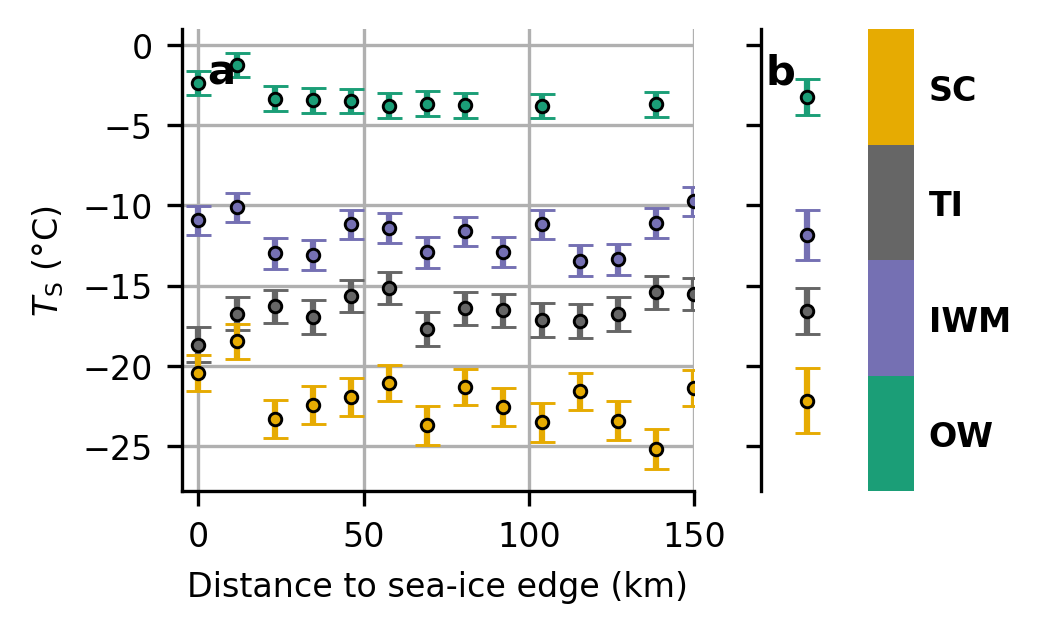

In [2]:
total_area = ds.segment_size.sum()

print('total area', total_area.values/1e4 ,'km²')

spacing = 15

dsgp_edge_dist = ds.groupby_bins('segment_edge_dist', np.linspace(0, 150, spacing))
dsgp_label = ds.groupby('segment_label').sum()

df = pd.DataFrame(
    columns=['Open Water', 'Snow Covered Ice', 'Thin Ice', 'Ice Water Mix'],
    data = np.zeros((spacing-1, 4)),
    #index=np.linspace(0, 200, 20)
)

def error_func(T):
    if T < 100:
        T += 273.15

    e_atm_sca = 0.477
    a_scs = 9.051  # K
    b_scs = 0.967  # K^-1
    e_atm_sca = 0.47  # K
    NETD_B5 = 0.473  # K
    a_b5 = 8.781  # K
    b_b5 = -0.031  # K^-1
    delta_T_B5 = (b_b5 * T + a_b5)
    delta_T_S_sca = np.sqrt(e_atm_sca**2 + b_scs**2 * NETD_B5**2 + (b_scs * delta_T_B5)**2)
    
    return delta_T_S_sca


df_error = pd.DataFrame(
    columns=['Open Water', 'Snow Covered Ice', 'Thin Ice', 'Ice Water Mix'],
    data = np.zeros((spacing-1, 4)),
)


df = df[['Open Water', 'Ice Water Mix', 'Thin Ice', 'Snow Covered Ice']]

#dsgp_edge_dist.segment_size.where(dsgp_edge_dist.segment_label == 2)

for i, group in enumerate(dsgp_edge_dist):
    open_water_mean = group[1].segment_T.where(group[1].segment_label == 1).values
    snow_covered_ice_mean = group[1].segment_T.where(group[1].segment_label == 3).values
    thin_ice_mean = group[1].segment_T.where(group[1].segment_label == 4).values
    ice_water_mix_mean = group[1].segment_T.where(group[1].segment_label == 2).values

    open_water_area = group[1].segment_size.where(group[1].segment_label == 1).values
    snow_covered_ice_area = group[1].segment_size.where(group[1].segment_label == 3).values
    thin_ice_area = group[1].segment_size.where(group[1].segment_label == 4).values
    ice_water_mix_area = group[1].segment_size.where(group[1].segment_label == 2).values


    open_water_mean = np.nansum(open_water_mean * open_water_area) / np.nansum(open_water_area)
    snow_covered_ice_mean = np.nansum(snow_covered_ice_mean * snow_covered_ice_area) / np.nansum(snow_covered_ice_area)
    thin_ice_area = np.nansum(thin_ice_mean * thin_ice_area) / np.nansum(thin_ice_area)
    ice_water_mix_area = np.nansum(ice_water_mix_mean * ice_water_mix_area) / np.nansum(ice_water_mix_area)


    total_area = 1
    df.loc[i, 'Open Water'] = open_water_mean / total_area
    df.loc[i, 'Snow Covered Ice'] = snow_covered_ice_mean / total_area
    df.loc[i, 'Thin Ice'] = thin_ice_area / total_area
    df.loc[i, 'Ice Water Mix'] = ice_water_mix_area / total_area

    df_error.loc[i, 'Open Water'] = error_func(open_water_mean)
    df_error.loc[i, 'Snow Covered Ice'] = error_func(snow_covered_ice_mean)
    df_error.loc[i, 'Thin Ice'] = error_func(thin_ice_area)
    df_error.loc[i, 'Ice Water Mix'] = error_func(ice_water_mix_area)

df.set_index(np.linspace(0, 150, spacing-1), inplace=True)
df_error.set_index(np.linspace(0, 150, spacing-1), inplace=True)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(3.15, 2),
                               gridspec_kw={'width_ratios': [1, .3]},
                               sharey=True)

#im = df.plot(stacked=False, cmap=cmap, ax=ax, alpha=.8, legend=False, linewidth=0, label='')
im = df.plot(cmap=cmap, alpha=.8, legend=False, label='', marker='o', ax=ax, markersize=2, linewidth=0)

#ax.legend(title='Surface type', loc='upper right', fontsize=6)
### add a colorbar instead of a legend

### make a colormap from listedcolors 

# from matplotlib.colors import ListedColormap

# cmap = ListedColormap(colors)

means = df.mean()
means_label = [1, 2, 3, 4]

#ax2.scatter([0,0,0,0], means, c=means_label, cmap=cmap, edgecolors='k', lw=.5, s=50)
ax2.set_xticks([])
ax2.spines[['top', 'right', 'bottom']].set_visible(False)

im = ax.contourf(np.array([[1, 2, 3, 4], [1, 2, 0, 4]]), cmap=cmap, alpha=1, levels=[0.5, 1.5, 2.5, 3.5, 4.5])
im.set_visible(False)

from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='50%', pad=0.05)

cbar = fig.colorbar(im, cax=cax, orientation='vertical', ticks=[1, 2, 3, 4])
cbar.set_ticklabels(['Open\nWater', 'Ice Water\nMix', 'Thin\nIce', 'Snow Covered\nIce'])
cbar.set_ticklabels(['OW', 'IWM', 'TI', 'SC'], fontweight='bold')
cbar.ax.yaxis.set_tick_params(width=0, length=0)
cbar.ax.yaxis.set_ticks_position('none')
cbar.ax.set_frame_on(False)

colors = np.array([[0.10588235, 0.61960784, 0.46666667, 1.],
                [0.45882353, 0.43921569, 0.70196078, 1.],
                [0.4       , 0.4       , 0.4       , 1.],
                [0.90196078, 0.67058824, 0.00784314, 1.],
])

print(error_func(273.15))   

ax.axes.grid(True)
# imi = (1 - ds.groupby_bins('segment_edge_dist', np.linspace(0, 150, 50)).mean().segment_sic / 100).plot(ax=ax, color='r', linestyle='--', linewidth=1, zorder=100)

# label = ['MODIS/AMSR 1-SIC']
# handles = imi

# ax.legend(handles, label, loc='upper right', fontsize=8)

ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('distance (km)')
# ax.text(-0.1, -0.35, '    Ice edge\n   (SIC = 10%)\n  ← Open Ocean', transform=ax.transAxes, fontweight='bold', fontsize=8)
# #ax.text(-0.27, -0.2, '← Open Ocean\n', transform=ax.transAxes, fontweight='bold', fontsize=6)
# #ax.text(0.8, -0.2, '→\n', transform=ax.transAxes, fontweight='bold', fontsize=6)
# ax.text(.9, -0.35 , 'Internal  →\nice zone \n', transform=ax.transAxes, fontweight='bold', fontsize=8)
ax.set_ylabel('$T_\mathrm{S}$ (°C)')
ax.axes.grid(True)
#ax.set_xlim([0, 150])
# ax.set_ylim([0, 1])
ax.set_xlabel('Distance to sea-ice edge (km)')


ax.text(0.05, 0.95, 'a', transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')
ax2.text(0.05, 0.95, 'b', transform=ax2.transAxes, fontsize=10, fontweight='bold', va='top')


#### fill a sheded area with the error + - the mean 

total_error  = (df.std()**2 + df_error.mean()**2)**.5

for i, col in enumerate(df.columns):
    #ax.fill_between(df.index, df.loc[:, col] - df_error.loc[:, col], df.loc[:, col] + df_error.loc[:, col], alpha=.4, color=colors[i])

    ax.errorbar(df.index, df.loc[:, col], yerr=df_error.loc[:, col], fmt='o', color=colors[i], markersize=3, label=col, capsize=3, capthick=2, markeredgecolor='black', markeredgewidth=.7)
    ax2.errorbar([0], means[col], yerr=total_error[col], fmt='o', color=colors[i], markersize=3, label='Total error', capsize=3, capthick=2, markeredgecolor='black', markeredgewidth=.7)


ax.set_xlim([-5, 150])




plt.savefig('../../plots/publish/figure09.png', bbox_inches='tight', dpi=300)



for m, e in zip(means, total_error):
    print(f'{m:.2f} ± {e:.2f}')
